In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import joblib

from matplotlib import pyplot as plt
# figure size
plt.rcParams['figure.figsize'] = (25, 5)

import torch

from darts.models import TFTModel
from darts import TimeSeries, concatenate
from darts.metrics import mape

import warnings

from src.utils import preprocess_data

warnings.filterwarnings("ignore")


import logging

logging.disable(logging.CRITICAL)

import argparse
import os
import json

/mnt/d/Google Drive/projects/paris-traffic-forecast


Importing plotly failed. Interactive plots will not work.


In [2]:
# load model
model = torch.load("models/model.pth")
model

In [3]:
data_dir = "tmp"
target_noeuds = ["Lecourbe-Convention", "Convention-Blomet"]
forecast_horizon = 24 * 5  # predict 5 days

In [4]:
# ## load data
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".pkl")]
all_arcs = []
for f in data_files:
    all_arcs.extend(joblib.load(f))

print(f"Loaded {len(all_arcs)} arcs")

# ## preprocess data
all_arcs = preprocess_data(all_arcs)

for arc in all_arcs:
    # set final target arc
    if [arc["noeud_amont"], arc["noeud_aval"]] == target_noeuds:
        target_arc = arc

# prepare past covs
past_covs = target_arc["past_covs_scaled"].univariate_component(0).append_values(np.ones(forecast_horizon))
future_covs = target_arc["past_covs_scaled"].univariate_component(1).append_values(np.zeros(forecast_horizon))
target_series = target_arc["train_scaled"].drop_after(pd.Timestamp("2021-12-10"))

Loaded 48 arcs


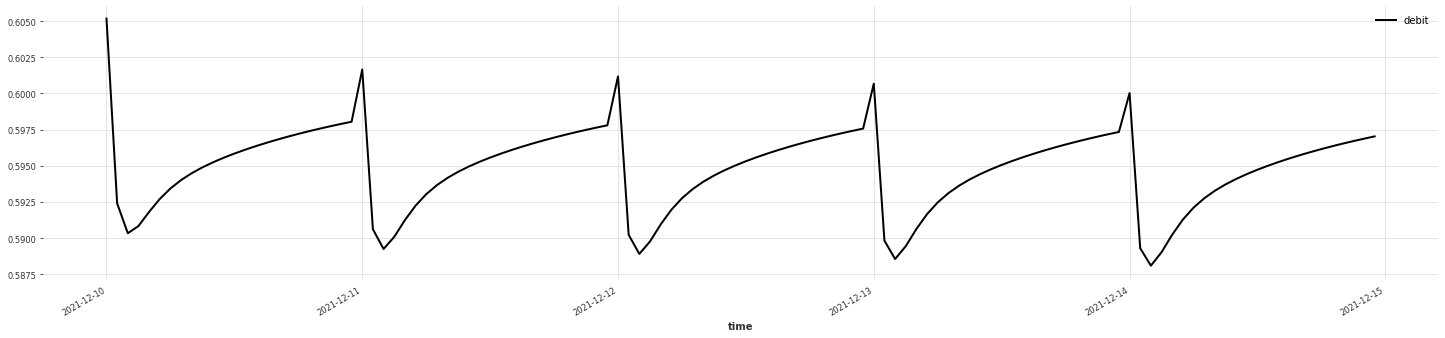

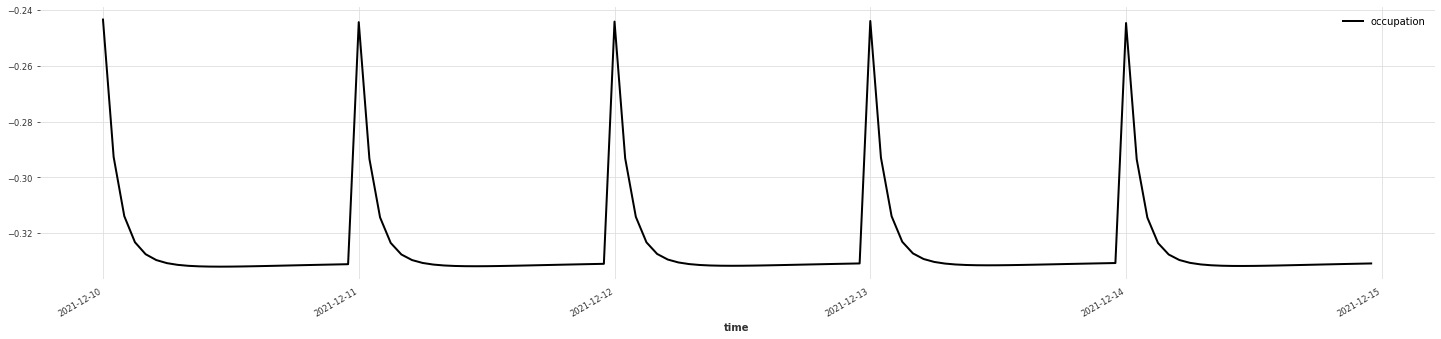

In [5]:
pred_ts = model.predict(
    forecast_horizon,
    series=target_series,
    past_covariates=past_covs,
    future_covariates=future_covs,
)

pred_ts.univariate_component(0).plot()
pred_ts.univariate_component(1).plot(new_plot=True)

In [6]:
backtest_series = model.historical_forecasts(
    target_series,
    past_covariates=past_covs,
    future_covariates=future_covs,
    start=target_arc["train_scaled"].end_time() - pd.Timedelta(days=15),
    # num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)


  0%|          | 0/2 [00:00<?, ?it/s]

MAPE: 718.80%


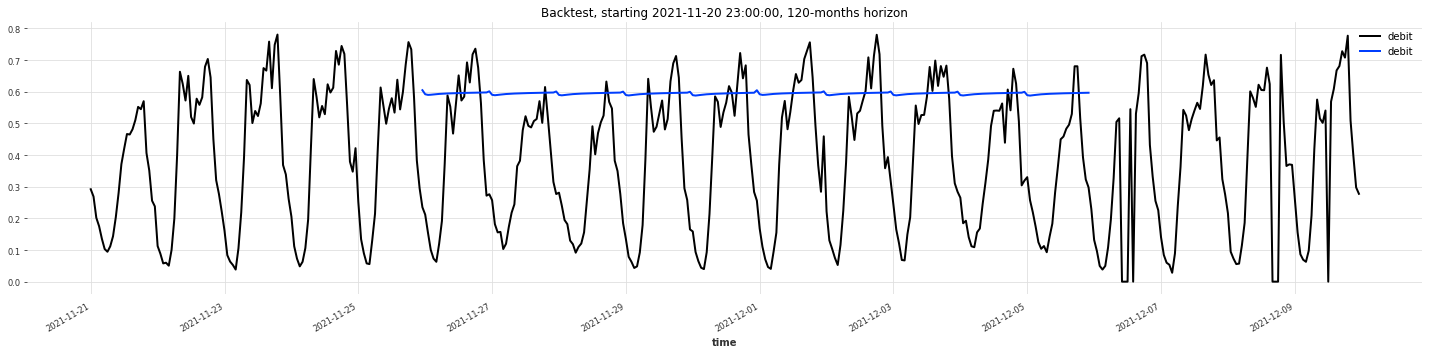

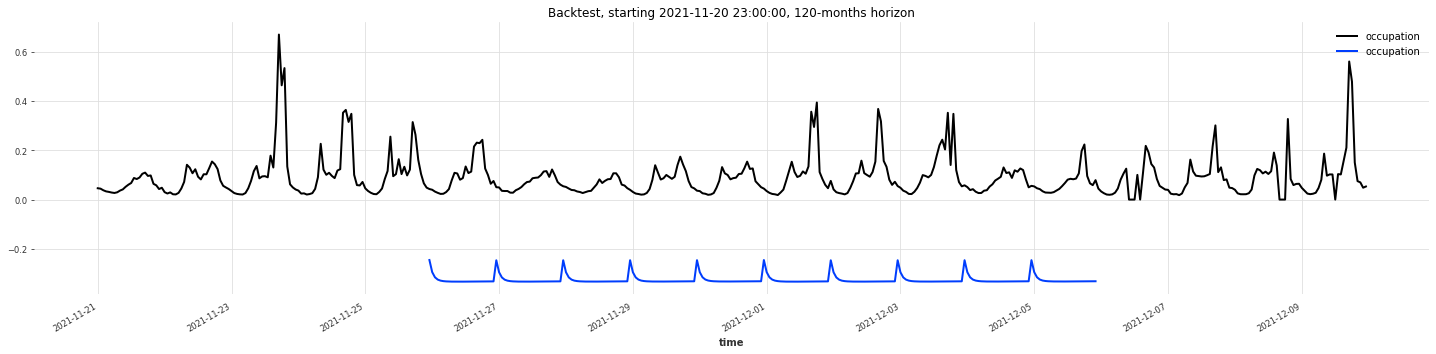

In [15]:
def eval_backtest(backtest_series, actual_series, transformer, horizon=None, start=None):
    actual_series.drop_before(start).univariate_component(0).plot()
    backtest_series.univariate_component(0).plot()
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    actual_series.drop_before(start).univariate_component(1).plot(new_plot=True)
    backtest_series.univariate_component(1).plot()
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-hours horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(transformer.inverse_transform(actual_series), transformer.inverse_transform(backtest_series))
        )
    )

eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=target_series,
    start=target_arc["train_scaled"].end_time() - pd.Timedelta(days=20),
    transformer=target_arc["targets_scaler"],
    horizon=forecast_horizon,
)


### export format for challenge

In [72]:
final = pd.DataFrame()
zz = zip(["champs", "convention", "sts"], ['Champs-Elysées', 'Convention', 'Saint-Pères'])
for name, arc in zz:
    all_df = pd.DataFrame()
    for filepath in [f"occ_{name}", f"db_{name}"]:
        df = pd.read_csv(f"data_final/{filepath}.csv").set_index('time')
        all_df = pd.concat([all_df, df], axis=1)

    all_df.index = pd.to_datetime(all_df.index, utc=False)
    all_df.sort_index(inplace=True)

    all_df = all_df.reset_index()
    all_df['time'] = all_df['time'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M"))
    all_df['arc'] = arc
    all_df.columns = ['datetime', 'taux_occupation', 'debit_horaire', 'arc']
    final = final.append(all_df)

final


,datetime,taux_occupation,debit_horaire,arc
0,2021-12-10 01:00,8.289153,828.786913,Champs-Elysées
1,2021-12-10 02:00,5.038057,687.432247,Champs-Elysées
2,2021-12-10 03:00,6.041186,481.509385,Champs-Elysées
3,2021-12-10 04:00,7.250014,363.551509,Champs-Elysées
4,2021-12-10 05:00,11.929735,370.899804,Champs-Elysées
...,...,...,...,...
115,2021-12-14 20:00,25.549896,679.205804,Saint-Pères
116,2021-12-14 21:00,22.818248,634.391457,Saint-Pères
117,2021-12-14 22:00,15.004148,467.801789,Saint-Pères
118,2021-12-14 23:00,14.373478,430.290809,Saint-Pères


In [73]:
final.describe()

,taux_occupation,debit_horaire
count,360.000000,360.000000
mean,12.295271,660.974026
std,9.392063,338.827398
min,-0.151419,45.285394
25%,4.498458,415.418454
50%,9.430295,635.742214
75%,20.115253,915.876235
max,47.518746,1512.953226


In [ ]:
df = preds_ts.pd_dataframe()
df = df.reset_index()
df['time'] = df['time'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M"))
df['arc'] = "Champs-Elysées"
df.columns = ['datetime', 'debit_horaire', 'taux_occupation', 'arc']
df

,datetime,debit_horaire,taux_occupation,arc
0,2021-12-06 01:00,793.0,9.02445,Champs-Elysées
1,2021-12-06 02:00,383.0,5.64000,Champs-Elysées
2,2021-12-06 03:00,248.0,2.93611,Champs-Elysées
3,2021-12-06 04:00,170.0,2.45333,Champs-Elysées
4,2021-12-06 05:00,189.0,1.67389,Champs-Elysées
...,...,...,...,...
91,2021-12-09 20:00,1342.0,32.55556,Champs-Elysées
92,2021-12-09 21:00,1099.0,24.96111,Champs-Elysées
93,2021-12-09 22:00,1040.0,22.91111,Champs-Elysées
94,2021-12-09 23:00,896.0,16.48389,Champs-Elysées


In [104]:
df1 = final[final.arc=="Champs-Elysées"]
df1.describe()

,taux_occupation,debit_horaire
count,120.000000,120.000000
mean,15.212896,974.796402
std,8.172311,252.915801
min,0.389768,319.091819
25%,8.045042,836.643323
50%,15.580685,1033.215412
75%,21.734673,1161.876777
max,34.858416,1512.953226


In [101]:
# replace negative values with 0
final.loc[final.taux_occupation < 0, 'taux_occupation'] = 0
final.describe()

,taux_occupation,debit_horaire
count,360.000000,360.000000
mean,12.295969,660.974026
std,9.391142,338.827398
min,0.000000,45.285394
25%,4.498458,415.418454
50%,9.430295,635.742214
75%,20.115253,915.876235
max,47.518746,1512.953226


In [102]:
df2 = final[final.arc=="Convention"]
df2.describe()

,taux_occupation,debit_horaire
count,120.000000,120.000000
mean,4.330267,562.430210
std,3.459298,300.210721
min,0.000000,54.352625
25%,1.449517,293.833140
50%,3.494615,573.136120
75%,6.468890,831.622238
max,18.170146,1009.744263


In [103]:
df2 = final[final.arc=="Saint-Pères"]
df2.describe()

,taux_occupation,debit_horaire
count,120.000000,120.000000
mean,17.344746,445.695466
std,9.436077,190.813346
min,0.938878,45.285394
25%,9.433934,291.457259
50%,17.174061,506.795408
75%,24.098036,597.076279
max,47.518746,689.144253


<AxesSubplot:>

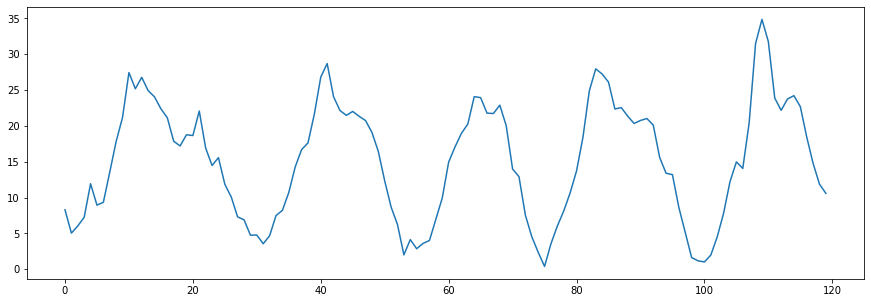

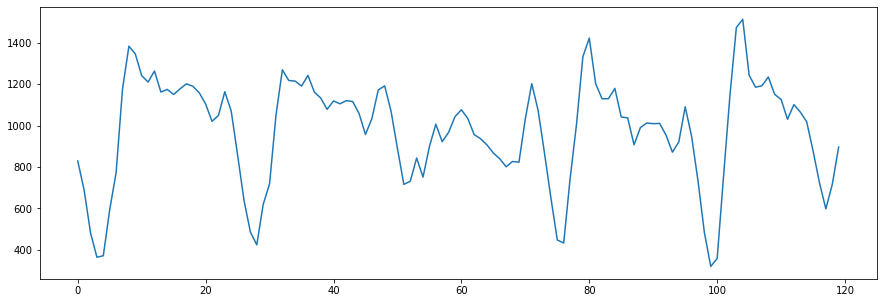

In [105]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
final[final.arc=="Champs-Elysées"].iloc[:,1].plot()
plt.figure()
final[final.arc=="Champs-Elysées"].iloc[:,2].plot()

In [106]:
final.arc.unique()

array(['Champs-Elysées', 'Convention', 'Saint-Pères'], dtype=object)

<AxesSubplot:>

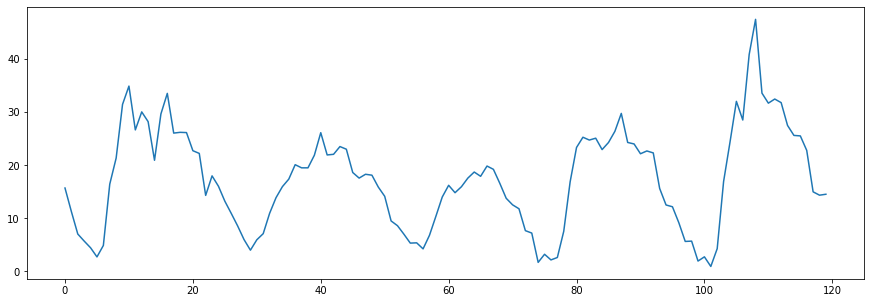

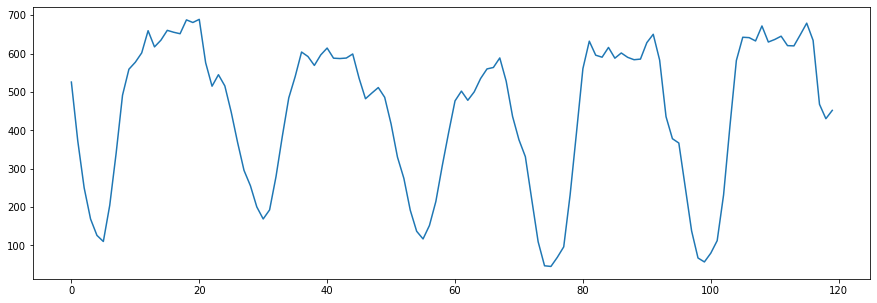

In [107]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
final[final.arc=="Saint-Pères"].iloc[:,1].plot()
plt.figure()
final[final.arc=="Saint-Pères"].iloc[:,2].plot()

<AxesSubplot:>

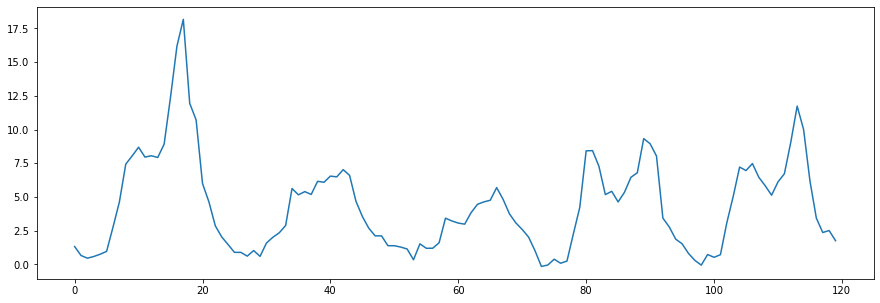

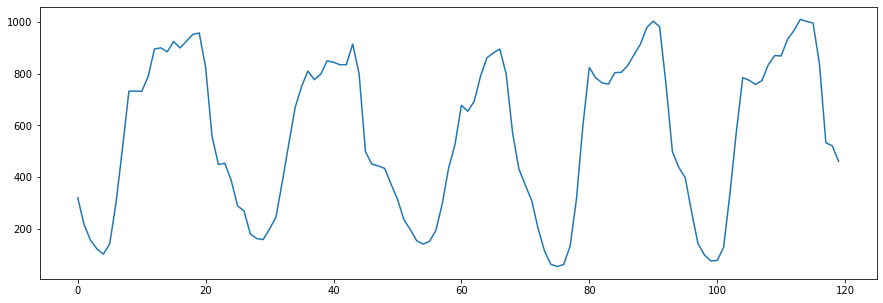

In [80]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
final[final.arc=="Convention"].iloc[:,1].plot()
plt.figure()
final[final.arc=="Convention"].iloc[:,2].plot()

In [108]:
from test_output import test_format_and_export_output
test_format_and_export_output(final, ".", "DatheCS")

[SAVE OUTPUT] Saving output here: output_DatheCS.csv
